In [2]:
# Imports
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from math import floor, log, sqrt
from numbers import Number
from statsmodels.graphics.tsaplots import plot_acf
import pymc3 as pm
import arviz as az

chptdat = pd.read_table(r'C:\Users\Nathan book\Desktop\COUP551_rates.dat', sep='\s+')
Y = chptdat['Cts']

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Case 2: changing distributions of b1 and b2
Here full conditional of theta and lambda is known
Full conditional of changepoint, b1 and b2 is unknown

In [3]:
# Programming an MCMC algorithm in Python
# MCMC algorithm for a Bayesian single change point model with k also sampled, initial k=10

KGUESS = 10

def mhsampler(NUMIT=1000, dat=Y):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((5, NUMIT))
    acc_k = 0 # count number of accepted proposals for k
    acc_b1 = 0 # count number of accepted proposals for b1
    acc_b2 = 0 # count number of accepted proposals for b2
    
    # starting values for markov chain
    kinit = 23
    mchain[:,0] = np.array([1, 1, kinit, 1, 1])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currtheta = mchain[0, i-1]
        currlambda = mchain[1, i-1]
        currk = mchain[2, i-1]
        currb1 = mchain[3, i-1]
        currb2 = mchain[4, i-1]
        
        # sample from full conditional distribution of theta (Gibbs update)
        currtheta = np.random.gamma(shape=sum(Y.iloc[:int(currk)])+0.5, scale=currb1/(currk*currb1 + 1))
        
        # sample from full conditional distribution of lambda (Gibbs update)
        currlambda = np.random.gamma(shape=sum(Y.iloc[int(currk):])+0.5, scale=currb2/((n-currk)*currb2+1))
        
        # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk = np.random.gamma(10,1)  # draw one sample at random from uniform{1,...,n-1}
        
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk)])*log(currtheta) + sum(Y.iloc[int(propk):])*log(currlambda) - propk*currtheta 
                     - (n-propk)*currlambda - (sum(Y.iloc[:int(currk)])*log(currtheta) + sum(Y.iloc[int(currk):])*log(currlambda) 
                                               - currk*currtheta - (n-currk)*currlambda))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_k += 1
            currk = propk
        
        # currk = KGUESS  # now we do sample k (k not fixed)
        
        # sample from full conditional distribution of b1 (Metropolis Hastings)
        propb1 = np.random.gamma(1,1.1)  
        
        # Metropolis accept-reject step (in log scale)
        logMHratio_b1 = (-(currtheta/propb1) - log(propb1**0.5) + (0.05-1)*log(propb1) - (propb1)/100) - (-(currtheta/currb1) - log(currb1**0.5) + (0.05-1)*log(currb1) - (currb1)/100)
        logalpha_b1 = min(0, logMHratio_b1)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha_b1:
            acc_b1 += 1
            currb1 = propb1
        
        # sample from full conditional distribution of b2 (Metropolis Hastings)
        propb2 = np.random.gamma(1.5,1)  
        
        # Metropolis accept-reject step (in log scale)
        logMHratio_b2 = (-(currlambda/propb2) - log(propb2**0.5) + (0.05-1)*log(propb2) - (propb2)/100) - (-(currlambda/currb2) - log(currb2**0.5) + (0.05-1)*log(currb2) - (currb2)/100)
        logalpha_b2 = min(0, logMHratio_b2)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha_b2:
            acc_b2 += 1
            currb2 = propb2
        
        # update chain with new values
        mchain[:,i] = np.array([currtheta, currlambda, currk, currb1, currb2])
        
    print(f"Markov chain algorithm ran for {NUMIT} iterations (acc.rate for k = {acc_k/(NUMIT-1)})")
    print(f"Markov chain algorithm ran for {NUMIT} iterations (acc.rate for b1 = {acc_b1/(NUMIT-1)})")
    print(f"Markov chain algorithm ran for {NUMIT} iterations (acc.rate for b2 = {acc_b2/(NUMIT-1)})")
    print("Parameters are in order: theta, lambda, k, b1, b2")
    return mchain

In [4]:
mchain = mhsampler(NUMIT=100000, dat=Y)
mchain

n= 46
Markov chain algorithm ran for 100000 iterations (acc.rate for k = 0.17119171191711918)
Markov chain algorithm ran for 100000 iterations (acc.rate for b1 = 0.3436934369343693)
Markov chain algorithm ran for 100000 iterations (acc.rate for b2 = 0.27622276222762226)
Parameters are in order: theta, lambda, k, b1, b2


array([[ 1.        ,  6.90465817,  6.30244732, ...,  6.24400895,
         5.21651054,  4.48763264],
       [ 1.        ,  7.23994701,  9.66108768, ...,  8.90262424,
         8.93712327,  8.84519135],
       [23.        , 10.66200073, 10.66200073, ..., 10.657907  ,
        10.657907  , 10.657907  ],
       [ 1.        ,  1.        ,  2.043093  , ...,  1.14351493,
         1.14351493,  1.14351493],
       [ 1.        ,  2.08809947,  2.08809947, ...,  2.25956097,
         3.06575813,  2.68043134]])

acceptance rate around 15%-35%

In [5]:
# Batch means
# Plot how Monte Carlo estimates change with increase in sample size

def estvssamp(samp, g=np.mean):
    if samp.size < 100:
        batchsize = 1
    else:
        batchsize = samp.size//100
    
    est = np.array([])
    for i in range(batchsize, samp.size+1, batchsize):
        est = np.append(est, g(samp[:i]))
    plt.figure()
    plt.plot(est)
    plt.title(f"Monte Carlo estimates with increasing samples (incr of {batchsize})")
    plt.figure()
    plt.plot(range(batchsize, samp.size+1, batchsize), est, '-')
    plt.title("Monte Carlo estimates vs sample size")

In [6]:
def bm(vals, bs="sqroot", warn=False):
    N = vals.size
    if N < 1000:
        if warn:
            print("WARNING: too few samples (less than 1000)")
        if N < 10:
            raise NotImplemented("NA")
    if bs == "sqroot":
        b = floor(sqrt(N))  # batch size
        a = floor(N/b)  # number of batches
    elif bs == "cuberoot":
        b = floor(N**(1/3))  # batch size
        a = floor(N/b)  # number of batches
    else:
        # batch size provided
        if not isinstance(bs, Number):
            raise NotImplemented("NA")
        b = floor(bs)  # batch size
        if b > 1:  # batch size valid
            a = floor(n/b)  # number of batches
        else:
            raise NotImplemented(f"Batch size invalid: bs = {bs}")
    function = lambda k : np.mean(vals[((k-1)*b+1):(k*b+1)])
    Ys = [function(i) for i in range(1, a+1)]
    
    muhat = np.mean(Ys)
    sigmahatsq = b*sum((Ys-muhat)**2)/(a-1)
    
    bmse = sqrt(sigmahatsq/N)
    
    return [f"est={muhat}", f"se={bmse}"]

Monte Carlo Estimates vs sample size plots for changepoints

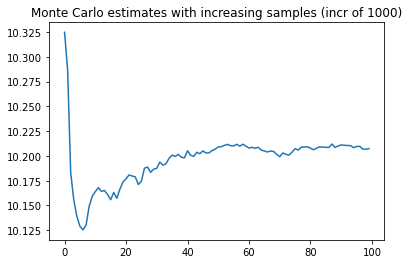

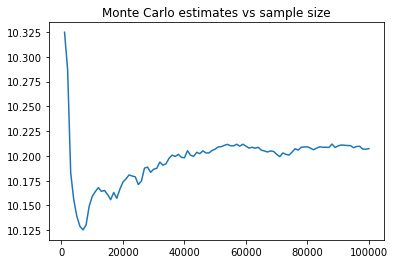

In [7]:
estvssamp(mchain[2,:])

Traceplot

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

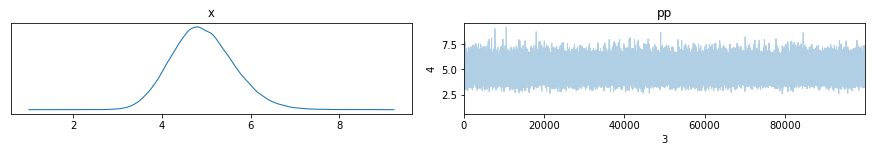

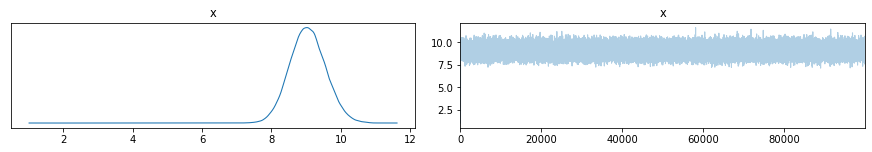

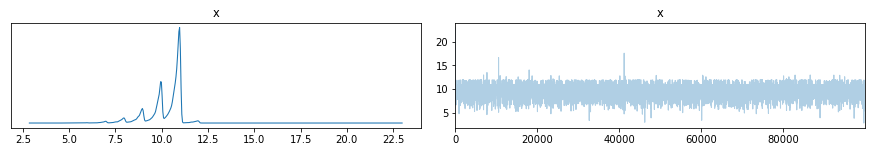

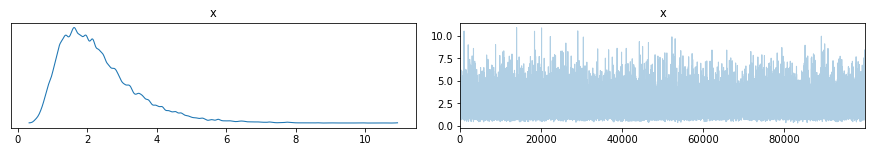

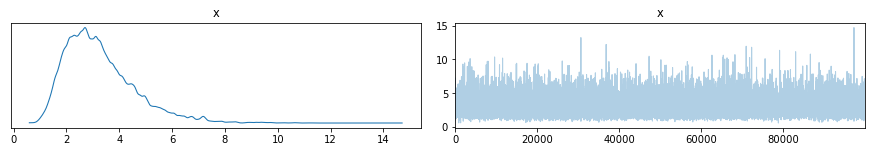

In [11]:
from arviz import plot_trace
plot_trace(mchain[0])
plt.title("p")
plt.xlabel("1")
plt.ylabel("2")
plt.title("pp")
plt.xlabel("3")
plt.ylabel("4")
plot_trace(mchain[1])
plot_trace(mchain[2])
plot_trace(mchain[3])
plot_trace(mchain[4])

Calculating the mean of the parameters.

In [8]:
print("Mean of first row (theta)is now", np.mean(mchain[0,:]))
print("Mean of second row (lambda)is now", np.mean(mchain[1,:]))
print("Mean of third row (changepoint)is now", np.mean(mchain[2,:]))
print("Mean of fourth row (b1)is now", np.mean(mchain[3,:]))
print("Mean of fifth row (b2)is now", np.mean(mchain[4,:]))

Mean of first row (theta)is now 4.928618821992893
Mean of second row (lambda)is now 9.050632140695843
Mean of third row (changepoint)is now 10.20616272416405
Mean of fourth row (b1)is now 2.3434205351232498
Mean of fifth row (b2)is now 3.2800459774690967


Calculating the mean of the parameters. Here take the last 1000 samples only

In [9]:
print("Mean of first row (theta)is now", np.mean(mchain[0,9000:]))
print("Mean of second row (lambda)is now", np.mean(mchain[1,9000:]))
print("Mean of third row (changepoint)is now", np.mean(mchain[2,9000:]))
print("Mean of fourth row (b1)is now", np.mean(mchain[3,9000:]))
print("Mean of fifth row (b2)is now", np.mean(mchain[4,9000:]))

Mean of first row (theta)is now 4.92774775633536
Mean of second row (lambda)is now 9.051306052804254
Mean of third row (changepoint)is now 10.211035630859287
Mean of fourth row (b1)is now 2.345049390628563
Mean of fifth row (b2)is now 3.2811386337461825


Smoothed density plots for parameters posterior

Text(0.5, 1.0, 'smoothed density plot for theta posterior')

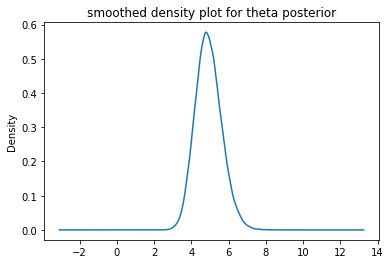

In [10]:
mchain_dataframe = pd.DataFrame(mchain)
plt.figure()
mchain_dataframe.iloc[0,:].plot(kind="density")
plt.title("smoothed density plot for theta posterior")

Text(0.5, 1.0, 'smoothed density plot for lambda posterior')

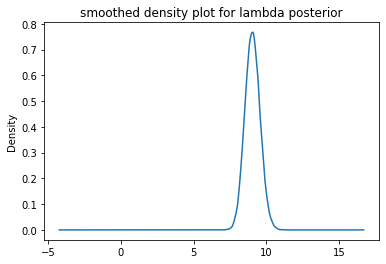

In [11]:
plt.figure()
mchain_dataframe.iloc[1,:].plot(kind="density")
plt.title("smoothed density plot for lambda posterior")

Text(0.5, 1.0, 'histogram for k posterior')

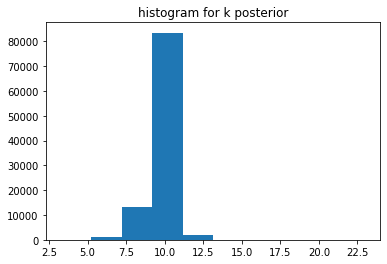

In [12]:
plt.figure()
plt.hist(mchain[2,:])
plt.title("histogram for k posterior")

Plotting the graphs of the last 1000 values only

(array([7.91881869e-03, 8.28133604e-02, 2.14348024e-01, 3.23925963e-01,
        3.57529522e-01, 3.19683739e-01, 2.72453642e-01, 2.17356147e-01,
        1.59353371e-01, 1.20684854e-01, 8.10136288e-02, 6.35562331e-02,
        3.56861050e-02, 2.42963755e-02, 1.95656527e-02, 1.22638848e-02,
        1.09012309e-02, 5.65629906e-03, 3.59946304e-03, 2.98241223e-03,
        1.95399422e-03, 3.34235854e-04, 4.62788105e-04, 4.62788105e-04,
        2.57104503e-04, 2.82814953e-04, 2.05683602e-04, 0.00000000e+00,
        0.00000000e+00, 1.02841801e-04]),
 array([ 0.65228213,  1.07969631,  1.50711049,  1.93452467,  2.36193885,
         2.78935302,  3.2167672 ,  3.64418138,  4.07159556,  4.49900974,
         4.92642392,  5.3538381 ,  5.78125227,  6.20866645,  6.63608063,
         7.06349481,  7.49090899,  7.91832317,  8.34573735,  8.77315152,
         9.2005657 ,  9.62797988, 10.05539406, 10.48280824, 10.91022242,
        11.3376366 , 11.76505078, 12.19246495, 12.61987913, 13.04729331,
        13.47470

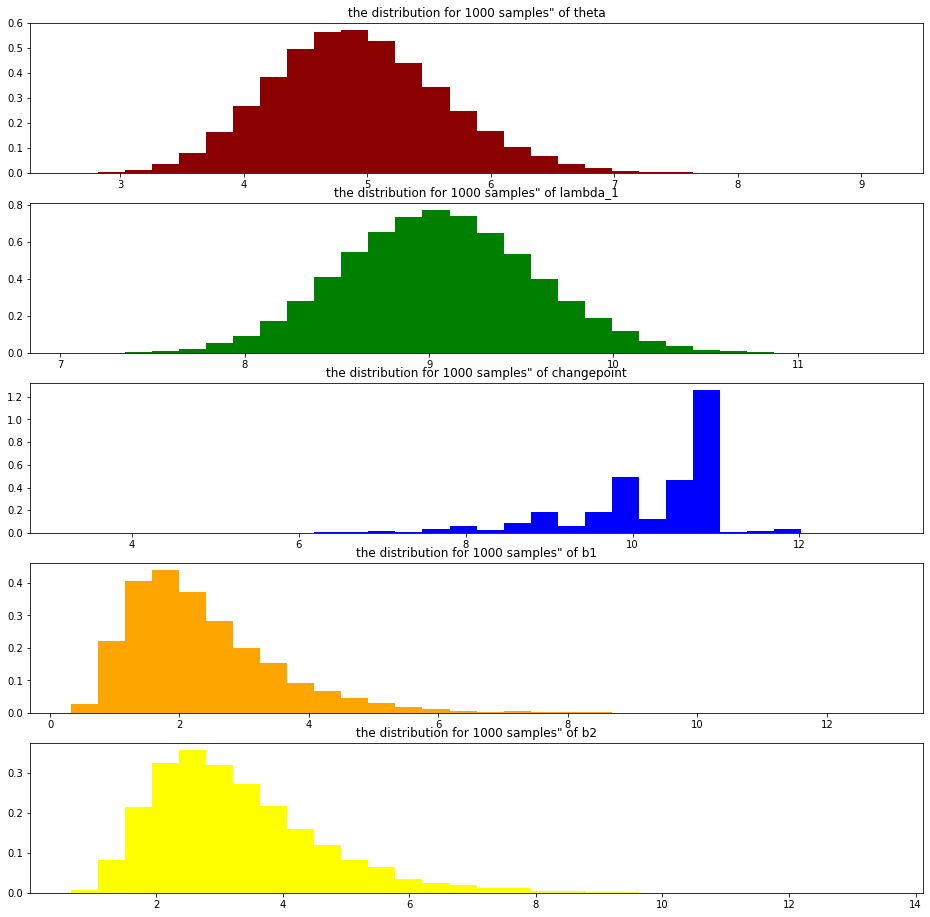

In [13]:
plt.figure(figsize=(16,16))
plt.subplot(511)
plt.title(r"""the distribution for 1000 samples" of theta""")
plt.hist(mchain[0,9000:], histtype = "stepfilled", color = "darkred",
         bins = 30, alpha = 1.0, density = True)

plt.subplot(512)
plt.title(r"""the distribution for 1000 samples" of lambda_1""")
plt.hist(mchain[1,9000:], histtype = "stepfilled", color = "green",
         bins = 30, alpha = 1.0, density = True)

plt.subplot(513)
plt.title(r"""the distribution for 1000 samples" of changepoint""")
plt.hist(mchain[2,9000:], histtype = "stepfilled", color = "blue",
         bins = 30, alpha = 1.0, density = True)

plt.subplot(514)
plt.title(r"""the distribution for 1000 samples" of b1""")
plt.hist(mchain[3,9000:], histtype = "stepfilled", color = "orange",
         bins = 30, alpha = 1.0, density = True)

plt.subplot(515)
plt.title(r"""the distribution for 1000 samples" of b2""")
plt.hist(mchain[4,9000:], histtype = "stepfilled", color = "yellow",
         bins = 30, alpha = 1.0, density = True)

Summary for the markov chain

In [14]:
pm.summary(mchain[0])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,4.929,0.705,3.595,6.229,0.003,0.002,64289.0,82729.0,NaN


In [15]:
pm.summary(mchain[1])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,9.051,0.516,8.092,10.024,0.002,0.002,50681.0,85158.0,NaN


In [16]:
pm.summary(mchain[2])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,10.206,0.94,7.954,11.0,0.011,0.008,4885.0,3821.0,NaN


In [17]:
pm.summary(mchain[3])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,2.343,1.148,0.655,4.441,0.009,0.006,18272.0,17668.0,NaN


In [18]:
pm.summary(mchain[4])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,3.28,1.347,1.188,5.751,0.013,0.009,12033.0,9534.0,NaN


# Model Checking
There are 2 components for model checking 
1. Convergence diagonstics
2. Goodness of fit

# 1. Convergence diagonstics
This includes:\
a. different starting values\
b. autocorrelation plots\
c. r_hat statistic\
d. credible intervals and r_hat statistic\
e. effective sample size

a. Different Initial Values\
Take Theta = 1, 5, 10, 15, 20, 25\
Take Lambda_1 = 1, 5, 10, 15, 20, 25\
Take checkpoint = 1, 5, 10, 15, 20, 25

In [19]:
# Programming an MCMC algorithm in Python
# MCMC algorithm for a Bayesian single change point model with k also sampled

KGUESS = 10

def mhsampler_ksampled(NUMIT=1000, dat=Y, init_T=1, init_A=1, init_K=23, init_B1=1, init_B2=1):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((5, NUMIT))
    acc = 0 # count number of accepted proposals (for k only)
    acc_b1= 0
    acc_b2 = 0
    
    # starting values for markov chain
    mchain[:,0] = np.array([init_T, init_A, init_K, init_B1, init_B2])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currtheta = mchain[0, i-1]
        currlambda = mchain[1, i-1]
        currk = mchain[2, i-1]
        currb1 = mchain[3, i-1]
        currb2 = mchain[4, i-1]
        
        # sample from full conditional distribution of theta (Gibbs update)
        currtheta = np.random.gamma(shape=sum(Y.iloc[:int(currk)])+0.5, scale=currb1/(currk*currb1 + 1))
        
        # sample from full conditional distribution of lambda (Gibbs update)
        currlambda = np.random.gamma(shape=sum(Y.iloc[int(currk):])+0.5, scale=currb2/((n-currk)*currb2+1))
        
        # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk = np.random.gamma(10,1)  # draw one sample at random from uniform{1,...,n-1}
        
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk)])*log(currtheta) + sum(Y.iloc[int(propk):])*log(currlambda) - propk*currtheta 
                     - (n-propk)*currlambda - (sum(Y.iloc[:int(currk)])*log(currtheta) + sum(Y.iloc[int(currk):])*log(currlambda) 
                                               - currk*currtheta - (n-currk)*currlambda))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc += 1
            currk = propk
        
        # currk = KGUESS  # now we do sample k (k not fixed)
        
        # sample from full conditional distribution of b1 (Metropolis Hastings)
        propb1 = np.random.gamma(1,1.1)  
        
        # Metropolis accept-reject step (in log scale)
        logMHratio_b1 = (-(currtheta/propb1) - log(propb1**0.5) + (0.05-1)*log(propb1) - (propb1)/100) - (-(currtheta/currb1) - log(currb1**0.5) + (0.05-1)*log(currb1) - (currb1)/100)
        logalpha_b1 = min(0, logMHratio_b1)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha_b1:
            acc_b1 += 1
            currb1 = propb1
        
        # sample from full conditional distribution of b2 (Metropolis Hastings)
        propb2 = np.random.gamma(1.5,1)  
        
        # Metropolis accept-reject step (in log scale)
        logMHratio_b2 = (-(currlambda/propb2) - log(propb2**0.5) + (0.05-1)*log(propb2) - (propb2)/100) - (-(currlambda/currb2) - log(currb2**0.5) + (0.05-1)*log(currb2) - (currb2)/100)
        logalpha_b2 = min(0, logMHratio_b2)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha_b2:
            acc_b2 += 1
            currb2 = propb2
        
        
        # update chain with new values
        mchain[:,i] = np.array([currtheta, currlambda, currk, currb1, currb2])
        
    return mchain

In [20]:
#Take Theta = 1, 5, 10, 15, 20, 25
m1 = mhsampler_ksampled(10000, Y, init_T = 1)
m2 = mhsampler_ksampled(10000, Y, init_T = 5)
m3 = mhsampler_ksampled(10000, Y, init_T = 10)
m4 = mhsampler_ksampled(10000, Y, init_T = 15)
m5 = mhsampler_ksampled(10000, Y, init_T = 20)
m6 = mhsampler_ksampled(10000, Y, init_T = 25)

n= 46
n= 46
n= 46
n= 46
n= 46
n= 46


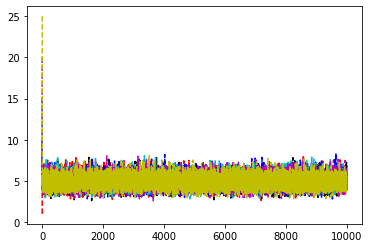

In [21]:
plt.plot(m1[0,:], 'r--')
plt.plot(m2[0,:], 'k--')
plt.plot(m3[0,:], 'b--')
plt.plot(m4[0,:], 'c--')
plt.plot(m5[0,:], 'm--')
plt.plot(m6[0,:], 'y--')

In [22]:
#Take Alpha = 1, 5, 10, 15, 20, 25
m1 = mhsampler_ksampled(10000, Y, init_A = 1)
m2 = mhsampler_ksampled(10000, Y, init_A = 5)
m3 = mhsampler_ksampled(10000, Y, init_A = 10)
m4 = mhsampler_ksampled(10000, Y, init_A = 15)
m5 = mhsampler_ksampled(10000, Y, init_A = 20)
m6 = mhsampler_ksampled(10000, Y, init_A = 25)

n= 46
n= 46
n= 46
n= 46
n= 46
n= 46


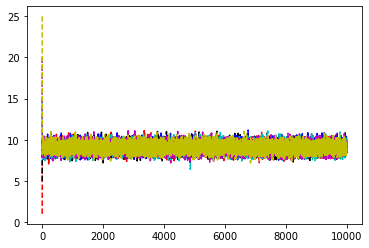

In [23]:
plt.plot(m1[1,:], 'r--')
plt.plot(m2[1,:], 'k--')
plt.plot(m3[1,:], 'b--')
plt.plot(m4[1,:], 'c--')
plt.plot(m5[1,:], 'm--')
plt.plot(m6[1,:], 'y--')

In [24]:
#Take changepoint = 1, 5, 10, 15, 20, 25
m1 = mhsampler_ksampled(10000, Y, init_K = 1)
m2 = mhsampler_ksampled(10000, Y, init_K = 5)
m3 = mhsampler_ksampled(10000, Y, init_K = 10)
m4 = mhsampler_ksampled(10000, Y, init_K = 15)
m5 = mhsampler_ksampled(10000, Y, init_K = 20)
m6 = mhsampler_ksampled(10000, Y, init_K = 25)

n= 46
n= 46
n= 46
n= 46
n= 46
n= 46


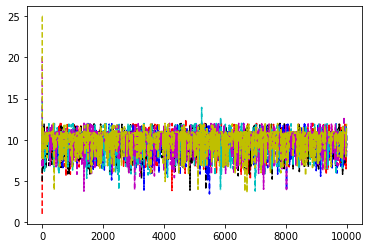

In [25]:
plt.plot(m1[2,:], 'r--')
plt.plot(m2[2,:], 'k--')
plt.plot(m3[2,:], 'b--')
plt.plot(m4[2,:], 'c--')
plt.plot(m5[2,:], 'm--')
plt.plot(m6[2,:], 'y--')

In [26]:
#Take b1 = 1, 2, 4, 6, 8, 10
m1 = mhsampler_ksampled(10000, Y, init_B1 = 1)
m2 = mhsampler_ksampled(10000, Y, init_B1 = 2)
m3 = mhsampler_ksampled(10000, Y, init_B1 = 4)
m4 = mhsampler_ksampled(10000, Y, init_B1 = 6)
m5 = mhsampler_ksampled(10000, Y, init_B1 = 8)
m6 = mhsampler_ksampled(10000, Y, init_B1 = 10)

n= 46
n= 46
n= 46
n= 46
n= 46
n= 46


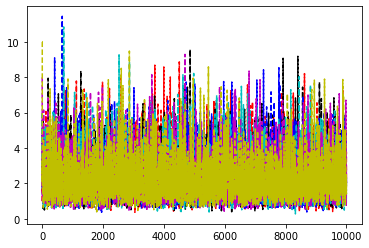

In [27]:
plt.plot(m1[3,:], 'r--')
plt.plot(m2[3,:], 'k--')
plt.plot(m3[3,:], 'b--')
plt.plot(m4[3,:], 'c--')
plt.plot(m5[3,:], 'm--')
plt.plot(m6[3,:], 'y--')

In [28]:
#Take b2 = 1, 2, 4, 6, 8, 10
m1 = mhsampler_ksampled(10000, Y, init_B2 = 1)
m2 = mhsampler_ksampled(10000, Y, init_B2 = 2)
m3 = mhsampler_ksampled(10000, Y, init_B2 = 4)
m4 = mhsampler_ksampled(10000, Y, init_B2 = 6)
m5 = mhsampler_ksampled(10000, Y, init_B2 = 8)
m6 = mhsampler_ksampled(10000, Y, init_B2 = 10)

n= 46
n= 46
n= 46
n= 46
n= 46
n= 46


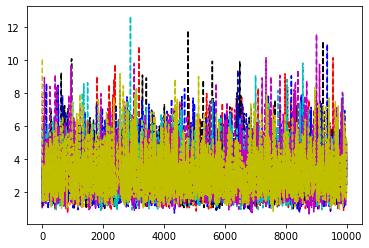

In [29]:
plt.plot(m1[4,:], 'r--')
plt.plot(m2[4,:], 'k--')
plt.plot(m3[4,:], 'b--')
plt.plot(m4[4,:], 'c--')
plt.plot(m5[4,:], 'm--')
plt.plot(m6[4,:], 'y--')

b. Autocorrelation Plots

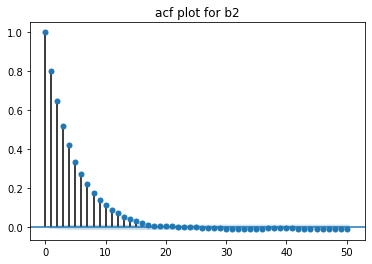

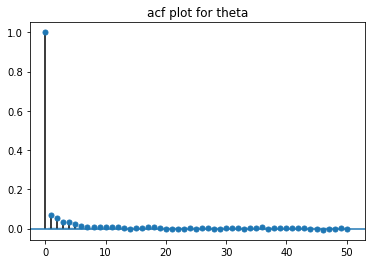

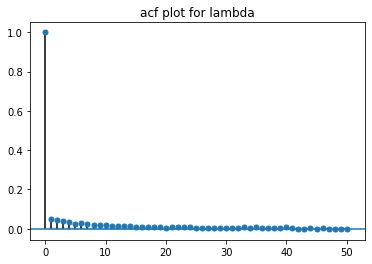

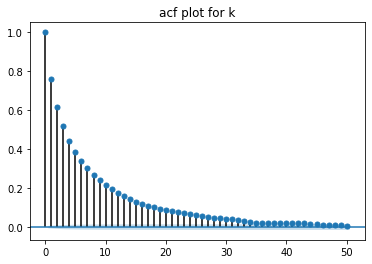

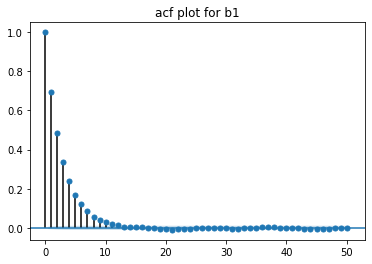

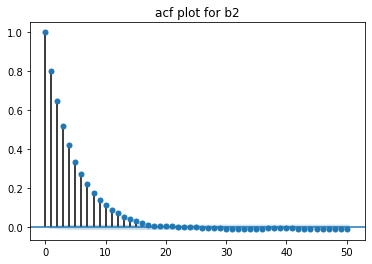

In [30]:
plot_acf(mchain[0,:], title="acf plot for theta")
plot_acf(mchain[1,:], title="acf plot for lambda")
plot_acf(mchain[2,:], title="acf plot for k")
plot_acf(mchain[3,:], title="acf plot for b1")
plot_acf(mchain[4,:], title="acf plot for b2")

c. rhat statistic

For theta, lambda, changepoint, b1 and b2 respectively

In [32]:
m=np.array([m1[0,:],m2[0,:],m3[0,:],m4[0,:],m5[0,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.0

In [33]:
m=np.array([m1[1,:],m2[1,:],m3[1,:],m4[1,:],m5[1,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.0

In [34]:
m=np.array([m1[2,:],m2[2,:],m3[2,:],m4[2,:],m5[2,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.004

In [35]:
m=np.array([m1[3,:],m2[3,:],m3[3,:],m4[3,:],m5[3,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.001

In [36]:
m=np.array([m1[4,:],m2[4,:],m3[4,:],m4[4,:],m5[4,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.001

all rhat statistic is around 1

d. credible intervals

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000225B3CD41C8>],
      dtype=object)

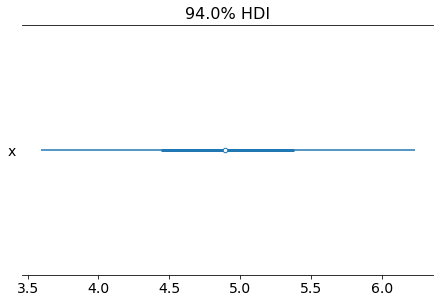

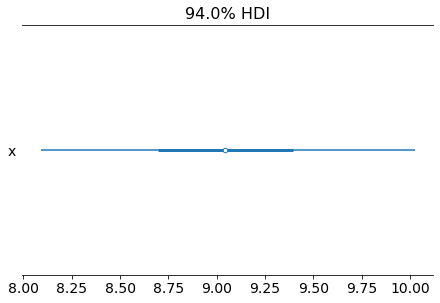

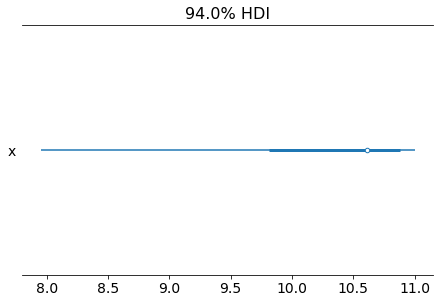

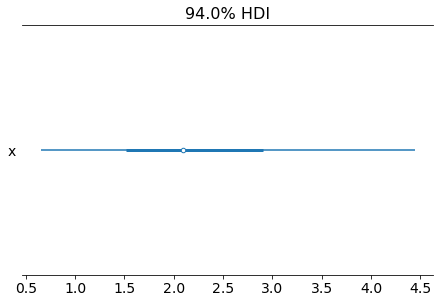

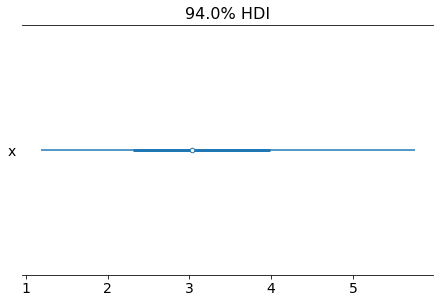

In [37]:
from arviz import plot_forest
plot_forest(mchain[0])
plot_forest(mchain[1])
plot_forest(mchain[2])
plot_forest(mchain[3])
plot_forest(mchain[4])

e. effective sample size

In [38]:
import arviz as az
print("Effective sample size for theta is", az.ess(mchain[0]))
print("Effective sample size for lambda is", az.ess(mchain[1]))
print("Effective sample size for changepoint is", az.ess(mchain[2]))
print("Effective sample size for b1 is", az.ess(mchain[3]))
print("Effective sample size for b2 is", az.ess(mchain[4]))

Effective sample size for theta is 64289.42669559708
Effective sample size for lambda is 50681.11077080325
Effective sample size for changepoint is 4885.15823750362
Effective sample size for b1 is 18271.584141905296
Effective sample size for b2 is 12033.052675468256


# 2. Goodness of fit

Evaluating model fit by comparing model predictions with the observations used to fit the model.

[[ 4  5  7  4  4  7  5  5  7  6  7  9 10 11  7 12 12  7  6 11  7  7 15 12
   6  8 16 12  4 11  6  7  9 10 11  7  8  9  4  7  8  8 10 10 12 14]
 [ 8  5  7  8 11  3  2  8  6  4  5  6  6  8 11  8  6  7 13 15  9  8 10  6
  11 12 13  7  7 16 13 11 14  5  6  5  9  8  9  7  5  7  8 10  9  5]
 [ 3  4  2  5  4  4  4  3  2  3 12  8 17  7 10 11 12  7 11  9  8  8  6  8
  13  6  5  6  3  8  6 19 10  9  7 11 12  9  5  9 12 12  8 10  5 15]
 [10  6  3  2  3 10  7  7  5  3  9  7 10  4  6  3  7 12  5  9  8 11  9  8
   7  6  4  5 12  4  4 10 10 10  6  6  3  6  6 12  6  9  7  9 11 12]
 [ 5  7  5  4  5  2  5  3  4  5  8 10 11  8  9  8  9  8  6  7  4 13  6 10
   5 11  8  7 10 10 11  7  3  9 12 10  4  6 10  7  8 12  7 11  9  6]
 [ 6  4  3  6 10  5  4  6  6  1 10  5 12  6  8  6 10  7  8  8 13  5 11  7
   6  4  8 11 10 10 12 10  5 10 10  7  6 15  4  6 11 10 16  3  9 10]
 [ 8  4  5  2  4  3  5  7  9  6 11  7  9 11 10 14 12  7  8  6 10 11 12  6
   8 10 13 14  9 11 12 13  4 12 10  5 11 14  9  9 10  7  8  6  6 10]

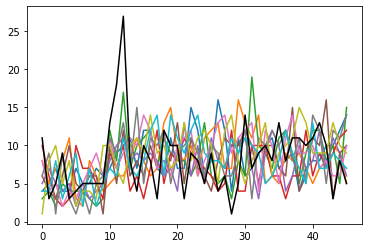

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
def generate_sample(num=1000):
    sample_set = []
    for i in range(num):
        temp_list =  np.random.poisson(4.929, size = 10)        
        second = np.random.poisson(9.051, size = 36)
        temp_list = np.append(temp_list, second)
        sample_set.append(temp_list)
    ya_da_ze = np.array(sample_set)
    print(ya_da_ze)
    return ya_da_ze
n = generate_sample(10)

plt.plot(n.T)
plt.plot(Y, "black")

Burn in algorithm

In [40]:
# try initial value for k=10
# Programming an MCMC algorithm in Python
# MCMC algorithm for a Bayesian single change point model with k also sampled, initial k=10

KGUESS = 10

def mhsampler_tune(NUMIT=10000, dat=Y, tune=1000):
    mchain_tune = mhsampler(NUMIT=tune, dat=Y)
    return mchain_tune
    
    #Now set the initial values of the mchain = last value of the mchain_tune
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((5, NUMIT))
    acc_k = 0 # count number of accepted proposals for k
    acc_b1 = 0 # count number of accepted proposals for b1
    acc_b2 = 0 # count number of accepted proposals for b2
    
    # starting values for markov chain
    mchain[:,0] = np.array([mchain_tune[0][tune-1], mchain_tune[1][tune-1], mchain_tune[2][tune-1], mchain_tune[3][tune-1], mchain_tune[4][tune-1]])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currtheta = mchain[0, i-1]
        currlambda = mchain[1, i-1]
        currk = mchain[2, i-1]
        currb1 = mchain[3, i-1]
        currb2 = mchain[4, i-1]
        
        # sample from full conditional distribution of theta (Gibbs update)
        currtheta = np.random.gamma(shape=sum(Y.iloc[:int(currk)])+0.5, scale=currb1/(currk*currb1 + 1))
        
        # sample from full conditional distribution of lambda (Gibbs update)
        currlambda = np.random.gamma(shape=sum(Y.iloc[int(currk):])+0.5, scale=currb2/((n-currk)*currb2+1))
        
        # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk = np.random.randint(1, n-1)  # draw one sample at random from uniform{1,...,n-1}
        
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk)])*log(currtheta) + sum(Y.iloc[int(propk):])*log(currlambda) - propk*currtheta 
                     - (n-propk)*currlambda - (sum(Y.iloc[:int(currk)])*log(currtheta) + sum(Y.iloc[int(currk):])*log(currlambda) 
                                               - currk*currtheta - (n-currk)*currlambda))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc_k += 1
            currk = propk
        
        # currk = KGUESS  # now we do sample k (k not fixed)
        
        # sample from full conditional distribution of b1 (Metropolis Hastings)
        propb1 = np.random.gamma(1,1.1)  
        
        # Metropolis accept-reject step (in log scale)
        logMHratio_b1 = (-(currtheta/propb1) - log(propb1**0.5) + (0.05-1)*log(propb1) - (propb1)/100) - (-(currtheta/currb1) - log(currb1**0.5) + (0.05-1)*log(currb1) - (currb1)/100)
        logalpha_b1 = min(0, logMHratio_b1)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha_b1:
            acc_b1 += 1
            currb1 = propb1
        
        # sample from full conditional distribution of b2 (Metropolis Hastings)
        propb2 = np.random.gamma(1.5,1)  
        
        # Metropolis accept-reject step (in log scale)
        logMHratio_b2 = (-(currlambda/propb2) - log(propb2**0.5) + (0.05-1)*log(propb2) - (propb2)/100) - (-(currlambda/currb2) - log(currb2**0.5) + (0.05-1)*log(currb2) - (currb2)/100)
        logalpha_b2 = min(0, logMHratio_b2)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha_b2:
            acc_b2 += 1
            currb2 = propb2
        
        # update chain with new values
        mchain[:,i] = np.array([currtheta, currlambda, currk, currb1, currb2])  
        
    print(f"Markov chain algorithm ran for {NUMIT} iterations (acc.rate for k = {acc_k/(NUMIT-1)})")
    print(f"Markov chain algorithm ran for {NUMIT} iterations (acc.rate for b1 = {acc_b1/(NUMIT-1)})")
    print(f"Markov chain algorithm ran for {NUMIT} iterations (acc.rate for b2 = {acc_b2/(NUMIT-1)})")
    print("Parameters are in order: theta, lambda, k, b1, b2")
    return mchain

In [41]:
mchain = mhsampler_tune(NUMIT=100000, dat=Y, tune=5000)

n= 46
Markov chain algorithm ran for 5000 iterations (acc.rate for k = 0.17163432686537308)
Markov chain algorithm ran for 5000 iterations (acc.rate for b1 = 0.35827165433086616)
Markov chain algorithm ran for 5000 iterations (acc.rate for b2 = 0.27645529105821165)
Parameters are in order: theta, lambda, k, b1, b2
